<h2><center>A Critical Assessment of the Big Data Approach to Crime Analysis</center></h1>

<h3>1. Introduction</h3>

<p style="text-align:justify">In a television documentary "Ross Kemp and the Armed Police" broadcast on the 6th of September 2018 by ITV, multiple claims were made regarding violent crime in the UK.

These claims were:
1. Violent Crime is increasing.
2. There are more firearms incidents per head in Birmingham than anywhere else in the UK.
3. Crimes involving firearms are closely associated with drugs offences.

The aim of this report is to investigate these claims. This report will apply a combination of Python, Apache Spark and Pandas to process, filter and display the data in a format which allows for the visualization of trends easily. PySpark will be used to filter the data to obtain and display the necessary data, while PySpark SQL will be used to create joins and finally the Pandas library will be used to transformations.</p>

<h3>2. Approach</h3>

<h4>2.1 Pre-requisites</h4>

The first step is to load all the necessary packages and pyspark, the visualization and machine learning functionalities.

In [1]:
#import packages that allow pyspark functionality
import pyspark
from pyspark import SparkContext, SparkConf

In [2]:
#This package is required for machine learning correlation such as Pearson an Spearman Correlation
import numpy as np
from pyspark.mllib.stat import Statistics

In [3]:
#This package is required to create useful visualization methods such as time series charts
import matplotlib.pyplot as plt
from matplotlib import pyplot

We need to create measures for error handling in order to ensure there are no multiple spark contexts running as this will create an error.

In [4]:
#If this code is rerun, it will lead to an error. Therefore, we apply a try and except message to prevent this.
try:
    conf=SparkConf().setMaster("local").setAppName("Crime Data Analysis")
    sc = SparkContext(conf=conf)
except:
    print("The Spark context already exists")

In [5]:
#import the SQL package for adding and renaming columns to tables as well as table joins
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

In [6]:
#This ensures that any figures are created and saved in the notebook and not in a new window
%matplotlib inline

In [7]:
#import spark session to alter and add a schema to the tables
from pyspark.sql import SparkSession

spark = SparkSession\
.builder\
.appName("Crime Data Analysis")\
.config("spark.some.config.option", "some-value")\
.getOrCreate()

In [8]:
sc

<SparkContext master=local appName=Crime Data Analysis>

In [9]:
#sql functions to add new columns to the tables
import pyspark.sql.functions as f

In [10]:
#pandas package to convert the dataframe to pandas and display the results in a more suitable format
import pandas as pd

<h3>2.2 Reading in the first dataset - Check that it has a header or not</h3>
<h4>2.2.1 Reading the data into an RDD</h4>

The data set which contains millions of rows of crime data in the UK is read into a variable.

In [11]:
lines = sc.textFile('../ass2/all_crimes18_hdr.txt.gz')

Next, we must ensure that the data has been properly and successfully read in. This step is also important because it allows us the chance to view the table header so we can find the fields and column names of any appropriate data.

In [12]:
#The first five lines will be displayed using this code
lines.take(5)

['Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-0.805600,51.819143,On or near Norfolk Terrace,E01017662,Aylesbury Vale 015C,Other crime,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494366,51.418169,On or near Keynsham Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511571,51.414895,On or near Orchard Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,']

In [13]:
#We will count the lines, using the code below, to make sure all the data has been read in
lines.count()

46986837

We can now observe that the data has been read in successfully.

The RDD is now filtered randomly to produce a more manageable amount of data for testing purposes.

In [13]:
#Randomly filtered lines
#(lines, linesNotNeeded) = lines.randomSplit([0.01, 0.99])

<h4>2.2.2 Splitting the lines into columns</h4>

The data will now be split into appropriate and usable data fields for filtering and grouping. We will also use this opportunity to filter out the data which is not required or useful for this analysis and leave only the useful data.

In [14]:
#function splits the lines into columns and gives an attribute name to each of the columns
def parseline(lines):
    fields = lines.split(',')
    Month = fields[1]
    LSOACode = fields[7]
    CrimeType = fields[9]
    Outcome = fields[10]
    return (Month, LSOACode, CrimeType, Outcome)

As the first line of the newly created RDD is the header, we must remove it as it is not useful and will lead to problems when filterng and grouping.

In [15]:
#the first row is a header, so it is located
header = lines.first()
#and then it is filtered out, leaving just the usable data behind.
justdata = lines.filter(lambda row: row != header)

Verification that the header has been rmoved is required.

In [16]:
justdata.take(5)

[',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-0.805600,51.819143,On or near Norfolk Terrace,E01017662,Aylesbury Vale 015C,Other crime,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494366,51.418169,On or near Keynsham Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511571,51.414895,On or near Orchard Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,']

As we can observe, the first line which contains the header has been removed from the RDD.

The data without the header must now be mapped using the above function to split the lines and associate each of the values to a corresponding field.

In [17]:
#The parseline function is used to map the RDD into a dataframe with column names.
content = justdata.map(parseline)

In [18]:
content.take(5)

[('2010-12', 'E01017662', 'Other crime', ''),
 ('2010-12', 'E01014399', 'Anti-social behaviour', ''),
 ('2010-12', 'E01014399', 'Anti-social behaviour', ''),
 ('2010-12', 'E01014399', 'Anti-social behaviour', ''),
 ('2010-12', 'E01014399', 'Anti-social behaviour', '')]

Here, we can observe that each line has now been split into fields.

<h4>2.2.3 Creating a Schema for the RDD</h4>

Now, we must create a schema with column headings for easier use later on when filtering and joining tables.

In [19]:
#A schema for the dataframe is created
from pyspark.sql.types import *
schema = StructType(
    [StructField("Month", StringType(), True),
    StructField("LSOACode", StringType(), True),
    StructField("CrimeType", StringType(), True),
    StructField("Outcome", StringType(), True)]
    )

A new dataframe is created using the content RDD and the above schema.

In [20]:
#The content from the above schema is added to a dataframe
allResults = spark.createDataFrame(content, schema)

We must now ensure that our schema has been correctly applied.

In [21]:
allResults.take(5)

[Row(Month='2010-12', LSOACode='E01017662', CrimeType='Other crime', Outcome=''),
 Row(Month='2010-12', LSOACode='E01014399', CrimeType='Anti-social behaviour', Outcome=''),
 Row(Month='2010-12', LSOACode='E01014399', CrimeType='Anti-social behaviour', Outcome=''),
 Row(Month='2010-12', LSOACode='E01014399', CrimeType='Anti-social behaviour', Outcome=''),
 Row(Month='2010-12', LSOACode='E01014399', CrimeType='Anti-social behaviour', Outcome='')]

We can now see that each value has a corresponding column name.

<h4>2.2.4 Group by Function</h4>

We need to see the list of crime types to give insight of the crime types and the correct name to filter by.

In [22]:
crimeList = allResults.groupBy('CrimeType').count()

In [24]:
crimeList.collect()

[Row(CrimeType='Charnwood 021E', count=375),
 Row(CrimeType='Bicycle theft', count=502391),
 Row(CrimeType='Public order', count=1319234),
 Row(CrimeType='Drugs', count=1163886),
 Row(CrimeType='Public disorder and weapons', count=242141),
 Row(CrimeType='Other crime', count=2271304),
 Row(CrimeType='Robbery', count=490235),
 Row(CrimeType='Hillingdon 009E', count=17),
 Row(CrimeType='Criminal damage and arson', count=3885733),
 Row(CrimeType='Charnwood 022D', count=28),
 Row(CrimeType='Theft from the person', count=477461),
 Row(CrimeType='Shoplifting', count=2375482),
 Row(CrimeType='Burglary', count=3407977),
 Row(CrimeType='Violent crime', count=1673194),
 Row(CrimeType='Other theft', count=3956838),
 Row(CrimeType='Hillingdon 011C', count=125),
 Row(CrimeType='Possession of weapons', count=159023),
 Row(CrimeType='Blaby 013C', count=41),
 Row(CrimeType='Violence and sexual offences', count=6133323),
 Row(CrimeType='Vehicle crime', count=3051734),
 Row(CrimeType='Bassetlaw 008B', c

This result has produced a list of all the stored crime data types in the database and the number of times that each of these incidents have occured. The crime types can now be filtered where necessary.

<h3>2.3 Is Violent Crime on the Increase?</h3>

<p style="text-align:justify">The first claim that was made in the documetary is that violent crime is on the increase. As defined by The Crown Prosecution Service <i>(Violent crime | The Crown Prosecution Service, 2021)</i>, violent crimes are defined as a range of offences that from common assault to murder. The definition also covers cases where weapons, like firearms, knives and corrosive substances (like acid) have been used.

We will now filter the dataframe so that only crimes that have been defined as violent by The Crown Prosecution Service are included. These include:

    1. Possession of weapons.
    2. Robbery.
    3. Gun and Knife Crime.
    4. Violent Crime.
    5. Violence and Sexual Offences.
    
We can then group this new dataset by the month column and count the number of instances that each month has. We will then plot this data on a Time Series graph to show the trend of how crime has changed over time.</p>

In [23]:
violentCrimeResults = allResults.filter((allResults.CrimeType == "Robbery") | 
                                        (allResults.CrimeType == "Violence and sexual offences") | 
                                        (allResults.CrimeType == "Possession of weapons") | 
                                        (allResults.CrimeType == "Robbery")
                                       )

The code below ensures that the filter has worked successfully and that only those with the crime type matching those outlined above will be displayed.

In [24]:
violentCrimeResults.take(5)

[Row(Month='2010-12', LSOACode='E01014402', CrimeType='Robbery', Outcome=''),
 Row(Month='2010-12', LSOACode='E01014370', CrimeType='Robbery', Outcome=''),
 Row(Month='2010-12', LSOACode='E01014371', CrimeType='Robbery', Outcome=''),
 Row(Month='2010-12', LSOACode='E01033080', CrimeType='Robbery', Outcome=''),
 Row(Month='2010-12', LSOACode='E01014461', CrimeType='Robbery', Outcome='')]

<h4>2.3.1 Data Format</h4>

For this next stage, we will group by month and count the number of instances in each month. We will then use this to see how the values have changed over time and if the number of cases have indeed risen, as the documenttary claimed. To execute this step, we will group the violentCrimeResults dataframe by the Month column, and then count the number of instances in each month, then order by Month to see an ordered time list.

In [25]:
violentCrimeResultsCountUnrenamed = violentCrimeResults.groupBy('Month').count().orderBy('Month')

To keep the data easy to read, the count column will be renamed to ViolentIncidents to better represent what information it is holding.

In [26]:
violentCrimeResultsCount = violentCrimeResultsCountUnrenamed.withColumnRenamed("count", "ViolentIncidents")

Now, we can display the findings and see if they are increasing.

In [27]:
violentCrimeResultsCount.collect()

[Row(Month='2010-12', ViolentIncidents=5731),
 Row(Month='2011-01', ViolentIncidents=6667),
 Row(Month='2011-02', ViolentIncidents=6480),
 Row(Month='2011-03', ViolentIncidents=6558),
 Row(Month='2011-04', ViolentIncidents=6275),
 Row(Month='2011-05', ViolentIncidents=6719),
 Row(Month='2011-06', ViolentIncidents=6226),
 Row(Month='2011-07', ViolentIncidents=6310),
 Row(Month='2011-08', ViolentIncidents=5960),
 Row(Month='2011-09', ViolentIncidents=5419),
 Row(Month='2011-10', ViolentIncidents=6098),
 Row(Month='2011-11', ViolentIncidents=6628),
 Row(Month='2011-12', ViolentIncidents=5727),
 Row(Month='2012-01', ViolentIncidents=6066),
 Row(Month='2012-02', ViolentIncidents=5570),
 Row(Month='2012-03', ViolentIncidents=6154),
 Row(Month='2012-04', ViolentIncidents=5626),
 Row(Month='2012-05', ViolentIncidents=5596),
 Row(Month='2012-06', ViolentIncidents=5498),
 Row(Month='2012-07', ViolentIncidents=5495),
 Row(Month='2012-08', ViolentIncidents=5311),
 Row(Month='2012-09', ViolentIncid

While it is clear to see that the cases of violent crimes have increased between December 2010 and July 2018, this data would be better represented in a time series graph to more effectively display this increase over time.

<h4>2.3.2 Time Series Graph Format</h4>

To execute this step, we will convert the dataframe above to pandas which can be used to plot time series graphs.

In [28]:
pandasViolentCrime = violentCrimeResultsCount.toPandas()

The Pandas dataframe can now be plotted with the x-axis displaying the time scale, and the y-axis showing the number of violent incidents that occured each at each time.

<function matplotlib.pyplot.show(*args, **kw)>

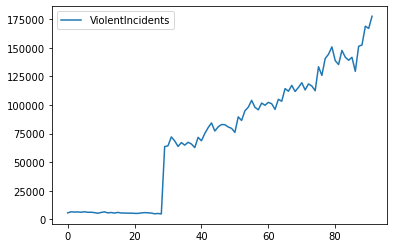

In [29]:
pandasViolentCrime.plot()
pyplot.show

<p style="text-align:justify">Now, we can clearly see from the graph that violent crime is on the increase, with a large rise taking place in 2013 and being sustained till July 2018, the most recent date recorded. We can further increase the usablitiy of this graph by adding a rolling mean value to highlight trends that occur over an extended period as opposed to those that occur over a short cycle. We can then find the mean over 12 months to see how the number of violent crimes changed year by year.</p>

In [30]:
rolmean = pandasViolentCrime.rolling(12).mean()

We can then plot the rolling mean as well as the original violent crime dataframe to display these trends over time. This can be done by plotting both on the same chart and adding appropriate labels and legends.

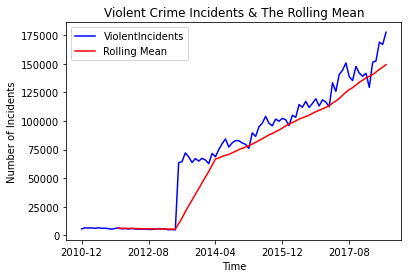

In [31]:
orig = pandasViolentCrime.plot(x = "Month", y = "ViolentIncidents", color = 'blue')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.ylabel("Number of Incidents")
plt.xlabel("Time")
plt.title('Violent Crime Incidents & The Rolling Mean')
plt.show(block=False)
pyplot.show()

<h4>2.3.3 Conclusion</h4>

It is clear to see that the number of violent crime incidents have increased over a period of eight years between December 2010 and July 2018. From this information, we can then say that the first claim made by the documentary is accurate.

<h3>2.4 Weapons Per Head</h3>

<p text-align:justify>The next claim that was made in the documentary is that there are more firearms incidents per head in birmingham than anywhere else in the UK.

Possession of firearms in the UK carries a mandatory prison sentence, according to The Crown Prosecution Service <i>(Firearms | The Crown Prosecution Service, 2021).</i>. Therefore, we will filter based on the crimetype and the outcome of the crime.</p>

We begin by importing the postrans file, which allows us translate the longitude and latitude of the crimes' dataset into actual postcodes.

In [32]:
postrans = sc.textFile('../ass2/posttrans.csv')

In [33]:
postrans.take(5)

['Postcode,Lon,Lat',
 'HP20 1BL,-0.805600,51.819143',
 'BS31 2BT,-2.494366,51.418169',
 'BS31 2PJ,-2.511927,51.409435',
 'BS31 2EG,-2.511571,51.414895']

In [35]:
postrans.count()

846261

We will process this dataset in the same format as we did in the previous section to remove headers and retrieve only the columns that are needed.

In [34]:
#function splits the lines into columns and gives an attribute name to each of the columns
def parseline(postrans):
    fields = postrans.split(',')
    Postcode = fields[0]
    Longitude = fields[1]
    Latitude = fields[2]
    return (Postcode, Longitude, Latitude)

In [35]:
#the first row is a header, so it is located
header = postrans.first()
#and then it is filtered out, leaving just the usable data behind.
posdata = postrans.filter(lambda row: row != header)

In [36]:
posdata.take(5)

['HP20 1BL,-0.805600,51.819143',
 'BS31 2BT,-2.494366,51.418169',
 'BS31 2PJ,-2.511927,51.409435',
 'BS31 2EG,-2.511571,51.414895',
 'BS31 2LQ,-2.513308,51.409456']

In [37]:
#The parseline function is used to map the RDD into a dataframe with column names.
cont = posdata.map(parseline)

In [38]:
cont.take(5)

[('HP20 1BL', '-0.805600', '51.819143'),
 ('BS31 2BT', '-2.494366', '51.418169'),
 ('BS31 2PJ', '-2.511927', '51.409435'),
 ('BS31 2EG', '-2.511571', '51.414895'),
 ('BS31 2LQ', '-2.513308', '51.409456')]

In [39]:
#A schema for the dataframe is created
from pyspark.sql.types import *
scheme = StructType(
    [StructField("Postcode", StringType(), True),
    StructField("Longitude", StringType(), True),
    StructField("Latitude", StringType(), True)]
    )

We then create a dataframe from the processes data set.

In [40]:
#The content from the above schema is added to a dataframe
postcodes = spark.createDataFrame(cont, scheme)

In [41]:
postcodes.take(5)

[Row(Postcode='HP20 1BL', Longitude='-0.805600', Latitude='51.819143'),
 Row(Postcode='BS31 2BT', Longitude='-2.494366', Latitude='51.418169'),
 Row(Postcode='BS31 2PJ', Longitude='-2.511927', Latitude='51.409435'),
 Row(Postcode='BS31 2EG', Longitude='-2.511571', Latitude='51.414895'),
 Row(Postcode='BS31 2LQ', Longitude='-2.513308', Latitude='51.409456')]

We then import the crimes' dataset again, with a different name, and process it into required format.

In [42]:
crimes = sc.textFile('../ass2/all_crimes18_hdr.txt.gz')

In [43]:
crimes.take(5)

['Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-0.805600,51.819143,On or near Norfolk Terrace,E01017662,Aylesbury Vale 015C,Other crime,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494366,51.418169,On or near Keynsham Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511571,51.414895,On or near Orchard Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,']

In [44]:
#function splits the lines into columns and gives an attribute name to each of the columns
def parseline(crimes):
    fields = crimes.split(',')
    Longitude = fields[4]
    Latitude = fields[5]
    LSOACode = fields[7]
    CrimeType = fields[9]
    Outcome = fields[10]
    return (Longitude, Latitude, LSOACode, CrimeType, Outcome)

In [45]:
#the first row is a header, so it is located
header = crimes.first()
#and then it is filtered out, leaving just the usable data behind.
crimedata = crimes.filter(lambda row: row != header)

In [46]:
crimedata.take(5)

[',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-0.805600,51.819143,On or near Norfolk Terrace,E01017662,Aylesbury Vale 015C,Other crime,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494366,51.418169,On or near Keynsham Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511571,51.414895,On or near Orchard Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,']

In [47]:
#The parseline function is used to map the RDD into a dataframe with column names.
crime = crimedata.map(parseline)

In [48]:
crime.take(5)

[('-0.805600', '51.819143', 'E01017662', 'Other crime', ''),
 ('-2.494366', '51.418169', 'E01014399', 'Anti-social behaviour', ''),
 ('-2.511927', '51.409435', 'E01014399', 'Anti-social behaviour', ''),
 ('-2.511571', '51.414895', 'E01014399', 'Anti-social behaviour', ''),
 ('-2.511927', '51.409435', 'E01014399', 'Anti-social behaviour', '')]

In [49]:
#A schema for the dataframe is created
from pyspark.sql.types import *
scheme1 = StructType(
    [StructField("Longitude", StringType(), True),
    StructField("Latitude", StringType(), True),
    StructField("LSOACode", StringType(), True),
    StructField("CrimeType", StringType(), True),
    StructField("Outcome", StringType(), True)]
    )

In [50]:
#The content from the above schema is added to a dataframe
crimes1 = spark.createDataFrame(crime, scheme1)

In [51]:
crimes1.take(5)

[Row(Longitude='-0.805600', Latitude='51.819143', LSOACode='E01017662', CrimeType='Other crime', Outcome=''),
 Row(Longitude='-2.494366', Latitude='51.418169', LSOACode='E01014399', CrimeType='Anti-social behaviour', Outcome=''),
 Row(Longitude='-2.511927', Latitude='51.409435', LSOACode='E01014399', CrimeType='Anti-social behaviour', Outcome=''),
 Row(Longitude='-2.511571', Latitude='51.414895', LSOACode='E01014399', CrimeType='Anti-social behaviour', Outcome=''),
 Row(Longitude='-2.511927', Latitude='51.409435', LSOACode='E01014399', CrimeType='Anti-social behaviour', Outcome='')]

At this point, both dataframes that have been created will be combined using the join command feature. As Longitude and Latitude are the common features, we will join the table based on these features.

In [52]:
df1 = crimes1.join(postcodes, ['Longitude', 'Latitude'])

In [53]:
df1.show()

+---------+---------+---------+--------------------+-------+--------+
|Longitude| Latitude| LSOACode|           CrimeType|Outcome|Postcode|
+---------+---------+---------+--------------------+-------+--------+
|-0.000043|51.546683|E01003617|         Other crime|       | E15 1QA|
|-0.000043|51.546683|E01003617|       Vehicle crime|       | E15 1QA|
|-0.000043|51.546683|E01003617|       Vehicle crime|       | E15 1QA|
|-0.000043|51.546683|E01003617|       Vehicle crime|       | E15 1QA|
|-0.000043|51.546683|E01003617|         Other crime|       | E15 1QA|
|-0.000043|51.546683|E01003617|         Other crime|       | E15 1QA|
|-0.000043|51.546683|E01003617|         Other crime|       | E15 1QA|
|-0.000043|51.546683|E01003617|       Violent crime|       | E15 1QA|
|-0.000043|51.546683|E01003617|             Robbery|       | E15 1QA|
|-0.000043|51.546683|E01003617|         Other crime|       | E15 1QA|
|-0.000043|51.546683|E01003617|Anti-social behav...|       | E15 1QA|
|-0.000043|51.546683

The LSOA data set is now imported. This data set file is where we will extract the area population.

In [54]:
lsoa = sc.textFile('../ass2/LSOA_pop_v2.csv')

In [55]:
lsoa.take(5)

['"date","geography","geography code","Rural Urban","Variable: All usual residents; measures: Value","Variable: Males; measures: Value","Variable: Females; measures: Value","Variable: Lives in a household; measures: Value","Variable: Lives in a communal establishment; measures: Value","Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value","Variable: Area (Hectares); measures: Value","Variable: Density (number of persons per hectare); measures: Value"',
 '2011,Darlington 001B,E01012334,Total,2466,1220,1246,2466,0,42,6033.58,0.4',
 '2011,Darlington 001C,E01012335,Total,1383,682,701,1383,0,21,114.01,12.1',
 '2011,Darlington 001D,E01012366,Total,2008,972,1036,2008,0,30,6718.16,0.3',
 '2011,Darlington 001E,E01033481,Total,1364,680,684,1350,14,21,146.95,9.3']

In [56]:
#function splits the lines into columns and gives an attribute name to each of the columns
def parseline(lsoa):
    fields = lsoa.split(',')
    LSOACode = fields[2]
    Population = fields[4]
    return (LSOACode, Population)

In [57]:
#the first row is a header, so it is located
header = lsoa.first()
#and then it is filtered out, leaving just the usable data behind.
lsoadata = lsoa.filter(lambda row: row != header)

In [58]:
#The parseline function is used to map the RDD into a dataframe with column names.
lsoaparse = lsoadata.map(parseline)

In [59]:
lsoaparse.take(5)

[('E01012334', '2466'),
 ('E01012335', '1383'),
 ('E01012366', '2008'),
 ('E01033481', '1364'),
 ('E01033482', '1621')]

In [60]:
#A schema for the dataframe is created
from pyspark.sql.types import *
schema2 = StructType(
    [StructField("LSOACode", StringType(), True),
    StructField("Population", StringType(), True)]
    )

A dataframe is now created from the processed data set.

In [61]:
#The content from the above schema is added to a dataframe
lsoadf = spark.createDataFrame(lsoaparse, schema2)

In [62]:
lsoadf.take(5)

[Row(LSOACode='E01012334', Population='2466'),
 Row(LSOACode='E01012335', Population='1383'),
 Row(LSOACode='E01012366', Population='2008'),
 Row(LSOACode='E01033481', Population='1364'),
 Row(LSOACode='E01033482', Population='1621')]

The LSOA dataframe will now be joined with the df1 dataframe created above.

In [76]:
df2 = df1.join(lsoadf, ['LSOACode'])

In [66]:
df2.show()

+---------+---------+---------+--------------------+-------+--------+----------+
| LSOACode|Longitude| Latitude|           CrimeType|Outcome|Postcode|Population|
+---------+---------+---------+--------------------+-------+--------+----------+
|E01000078| 0.130484|51.550051|Anti-social behav...|       | RM9 5XT|      1666|
|E01000078| 0.130484|51.550051|Anti-social behav...|       | RM9 5XT|      1666|
|E01000078| 0.130484|51.550051|Anti-social behav...|       | RM9 5XT|      1666|
|E01000078| 0.130484|51.550051|Anti-social behav...|       | RM9 5XT|      1666|
|E01000078| 0.130484|51.550051|Anti-social behav...|       | RM9 5XT|      1666|
|E01000078| 0.130484|51.550051|Anti-social behav...|       | RM9 5XT|      1666|
|E01000078| 0.130484|51.550051|Anti-social behav...|       | RM9 5XT|      1666|
|E01000078| 0.130484|51.550051|Anti-social behav...|       | RM9 5XT|      1666|
|E01000078| 0.130484|51.550051|Anti-social behav...|       | RM9 5XT|      1666|
|E01000078| 0.130484|51.5500

The deprivation data set is imported for extracting the location data. We will process it as other data files have been done prviously.

In [63]:
deprivation = sc.textFile('../ass2/deprivation_with_hdr.gz')

In [64]:
deprivation.take(5)

['LSOA CODE,PRE 2009 LA CODE,PRE 2009 LA NAME,POST 2009 LA CODE,POST 2009 LA NAME,GOR CODE,GOR NAME,IMD SCORE,RANK OF IMD SCORE (where 1 is most deprived),INCOME SCORE,RANK OF INCOME SCORE (where 1 is most deprived),EMPLOYMENT SCORE,RANK OF EMPLOYMENT SCORE (where 1 is most deprived),HEALTH DEPRIVATION AND DISABILITY SCORE,RANK OF HEALTH DEPRIVATION AND DISABILITY SCORE (where 1 is most deprived),EDUCATION SKILLS AND TRAINING SCORE,RANK OF EDUCATION SKILLS AND TRAINING SCORE (where 1 is most deprived),BARRIERS TO HOUSING AND SERVICES SCORE,RANK OF BARRIERS TO HOUSING AND SERVICES SCORE (where 1 is most deprived),CRIME AND DISORDER SCORE,RANK OF CRIME SCORE (where 1 is most deprived),LIVING ENVIRONMENT SCORE,RANK OF LIVING ENVIRONMENT SCORE (where 1 is most deprived),Indoors Sub-domain Score,Indoors Sub-domain Rank (where 1 is most deprived),Outdoors Sub-domain Score,Outdoors Sub-domain Rank (where 1 is most deprived),Geographical Barriers Sub-domain Score,Geographical Barriers Sub-doma

This helps us to retrieve data in the 'LSOACode' and 'Location' columns. The LSOACode column helps us to combine this data with data in the previous table.

In [65]:
#function splits the lines into columns and gives an attribute name to each of the columns
def parseline(deprivation):
    fields = deprivation.split(',')
    LSOACode = fields[0]
    Location = fields[2]
    return (LSOACode, Location)

In [66]:
#the first row is a header, so it is located
header = deprivation.first()
#and then it is filtered out, leaving just the usable data behind.
depdata = deprivation.filter(lambda row: row != header)

In [67]:
depdata.take(5)

['E01000001,00AA,City of London,00AA,City of London,H,London,6.16,28814,0.01,32460,0.01,32435,-2.11,32332,0.21,32421,32.6,5491,-1.64,31816,26.28,10212,20.76,12921,37.32,6070,6.2,24711,59.01,2105,0.41,31905,0.01,32462,0.04,28761,0,32456',
 'E01000002,00AA,City of London,00AA,City of London,H,London,5.59,29450,0.01,32457,0.01,32452,-2.78,32472,0.26,32392,30.26,6980,-1.93,32269,25.73,10483,15.74,16178,45.72,4083,2.14,29561,58.37,2176,0.5,31775,0.02,32452,0,32415,0.03,32339',
 'E01000003,00AA,City of London,00AA,City of London,H,London,13.29,20047,0.07,22562,0.05,26026,-0.97,28188,7.16,24611,40.32,2211,-1.21,30147,36.48,6088,20.56,13035,68.32,1263,0.78,31387,79.86,597,13.65,17752,0.66,31549,0.19,13938,0.18,14932',
 'E01000004,00AA,City of London,00AA,City of London,H,London,11.17,22503,0.04,30002,0.04,28814,-1.04,28814,1.76,30899,37.92,3012,-1.32,30744,46.72,3257,32.45,7602,75.25,824,11.19,19802,64.64,1556,3.3,28082,0.22,32166,0.05,27689,0.07,29527',
 'E01000005,00AA,City of London,00AA,Ci

In [68]:
#The parseline function is used to map the RDD into a dataframe with column names.
deparse = depdata.map(parseline)

In [69]:
deparse.take(5)

[('E01000001', 'City of London'),
 ('E01000002', 'City of London'),
 ('E01000003', 'City of London'),
 ('E01000004', 'City of London'),
 ('E01000005', 'City of London')]

In [70]:
#A schema for the dataframe is created
from pyspark.sql.types import *
schema3 = StructType(
    [StructField("LSOACode", StringType(), True),
    StructField("Location", StringType(), True)]
    )

In [71]:
#The content from the above schema is added to a dataframe
depdf = spark.createDataFrame(deparse, schema3)

In [72]:
depdf.take(5)

[Row(LSOACode='E01000001', Location='City of London'),
 Row(LSOACode='E01000002', Location='City of London'),
 Row(LSOACode='E01000003', Location='City of London'),
 Row(LSOACode='E01000004', Location='City of London'),
 Row(LSOACode='E01000005', Location='City of London')]

Now, we will attemp to join all dataframes that have been created together.

In [73]:
df4 = lsoadf.join(depdf, ['LSOACode'])

In [ ]:
df4.show()

<p style="text-align:justify">Here, we filter our results to obtain only data pertaining to our intended results, which is data relating to arrests relating to possession of weapons. We add the extra filter of the outcome, as according to the crown prosecution service, possession of weapons such as firearms carries a mandatory prison sentence. So, we will make an assumption that arrests that ended up with a prison sentence in this category included offenders who carried firearms.</p>

In [77]:
firearmsResults = df2.filter((df2.CrimeType == "Possession of weapons") & 
                            (df2.Outcome == "Offender sent to prison") 
                            )

In [78]:
firearmsResults.take(5)

[Row(LSOACode='E01000975', Longitude='-0.091592', Latitude='51.376017', CrimeType='Possession of weapons', Outcome='Offender sent to prison', Postcode='CR0 6BT', Population='1613'),
 Row(LSOACode='E01001697', Longitude='0.067596', Latitude='51.483560', CrimeType='Possession of weapons', Outcome='Offender sent to prison', Postcode='SE18 6TY', Population='2094'),
 Row(LSOACode='E01001876', Longitude='-0.233443', Latitude='51.515072', CrimeType='Possession of weapons', Outcome='Offender sent to prison', Postcode='W12 7AD', Population='2232'),
 Row(LSOACode='E01002965', Longitude='-0.308139', Latitude='51.403417', CrimeType='Possession of weapons', Outcome='Offender sent to prison', Postcode='KT1 2LZ', Population='2325'),
 Row(LSOACode='E01004173', Longitude='-0.145980', Latitude='51.367457', CrimeType='Possession of weapons', Outcome='Offender sent to prison', Postcode='SM6 8BE', Population='1385')]

In [79]:
depdfResults = depdf.filter(depdf.Location == "Birmingham")

In [80]:
depdfResults.show()

+---------+----------+
| LSOACode|  Location|
+---------+----------+
|E01008881|Birmingham|
|E01008882|Birmingham|
|E01008883|Birmingham|
|E01008884|Birmingham|
|E01008885|Birmingham|
|E01008886|Birmingham|
|E01008887|Birmingham|
|E01008888|Birmingham|
|E01008889|Birmingham|
|E01008890|Birmingham|
|E01008891|Birmingham|
|E01008892|Birmingham|
|E01008893|Birmingham|
|E01008894|Birmingham|
|E01008895|Birmingham|
|E01008896|Birmingham|
|E01008897|Birmingham|
|E01008898|Birmingham|
|E01008899|Birmingham|
|E01008900|Birmingham|
+---------+----------+
only showing top 20 rows



<h1><center>Conclusion</center></h1>

<p style="text-align:justify">
From the above data analysis, we can conclude that some of the claims made in the documentary were true, while others 
were not accurate.
</p>

<h1><center>References</center></h1>

Firearms | The Crown Prosecution Service. [online] Available at: <https://www.cps.gov.uk/legal-guidance/firearms> [Accessed 14 January 2021].

Violent crime | The Crown Prosecution Service. [online] Available at: https://www.cps.gov.uk/crime-info/violent-crime.